In [1]:
%matplotlib inline

Parallel Computing
==============

**Suhas Somnath, Chris R. Smith**

9/8/2017

Introduction
-------------
Quite often, we need to perform the same operation on every single component in our data. One of the most popular
examples is functional fitting applied to spectra collected at each location on a grid. While, the operation itself
may not take very long, computing this operation thousands of times, once per location, using a single CPU core can
take a long time to complete. Most personal computers today come with at least two cores, and in many cases, each of
these cores is represented via two logical cores, thereby summing to a total of at least four cores. Thus, it is
prudent to make use of these unused cores whenever possible. Fortunately, there are a few python packages that
facilitate the efficient use of all CPU cores with minimal modifications to the existing code.

**pycroscopy.parallel_compute()** simplifies parallel computing by ensuring that appropriate number of CPU cores are used for the requested computation.

Example scientific problem
---------------------------
For this example, we will be working with a Band Excitation Piezoresponse Force Microscopy (BE-PFM) imaging dataset
acquired from advanced atomic force microscopes. In this dataset, a spectra was collected for each position in a two
dimensional grid of spatial locations. Thus, this is a three dimensional dataset that has been flattened to a two
dimensional matrix in accordance with the pycroscopy data format.

Each spectra in this dataset is expected to have a single peak. The goal is to find the positions of the peaks in each spectra. Clearly, the operation of finding the peak in one spectra is independent of the same operation on another spectra. Thus, we could in theory divide the dataset in to N parts and use N CPU cores to compute the results much faster than it would take a single core to compute the results. There is an important caveat to this statement and it will be discussed at the end of this document. 

**Here, we will learn how to fit the thousands of spectra using all available cores on a computer.** 
Note, that this is applicable only for a single CPU. Please refer to another advanced example for multi-CPU computing.

In [2]:
# Ensure python 3 compatibility:
from __future__ import division, print_function, absolute_import, unicode_literals

# The package for accessing files in directories, etc.:
import os

# Warning package in case something goes wrong
from warnings import warn

# Package for downloading online files:
try:
    # This package is not part of anaconda and may need to be installed.
    import wget
except ImportError:
    warn('wget not found.  Will install with pip.')
    import pip
    pip.main(['install', 'wget'])
    import wget

# The mathematical computation package:
import numpy as np

# The package used for creating and manipulating HDF5 files:
import h5py

# Packages for plotting:
import matplotlib.pyplot as plt

# Parallel computation library:
try:
    import joblib
except ImportError:
    warn('joblib not found.  Will install with pip.')
    import pip
    pip.main(['install', 'joblib'])
    import joblib

# Timing
import time

# A handy python utility that allows us to preconfigure parts of a function
from functools import partial

# Function for reading the number of CPU cores on this computer:
from multiprocessing import cpu_count

# Finally import pycroscopy for certain scientific analysis:
if True:
    import sys
    sys.path.append(os.path.split(os.path.abspath('.'))[0])
    import pycroscopy as px
else:
    try:
        import pycroscopy as px
    except ImportError:
        warn('pycroscopy not found.  Will install with pip.')
        import pip
        pip.main(['install', 'pycroscopy'])
        import pycroscopy as px

//anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/syz/PycharmProjects/pycroscopy/pycroscopy/__init__.py:25: UserWarning: You are using the unity_dev branch, which is aimed at a 1.0 release for pycroscopy. Be advised - this branch changes very significantly and frequently. Use the master or dev branches for regular purposes.
  warn('You are using the unity_dev branch, which is aimed at a 1.0 release for pycroscopy. '


Load the dataset
--------------------
In order to demonstrate parallel computing, we will be using a real experimental dataset that is available on the pycroscopy GitHub project. First, lets download this file from Github:

In [3]:
# download the raw data file from Github:
h5_path = 'temp.h5'
url = 'https://raw.githubusercontent.com/pycroscopy/pycroscopy/master/data/BELine_0004.h5'
if os.path.exists(h5_path):
    os.remove(h5_path)
_ = wget.download(url, h5_path)

Now, lets open this HDF5 file and see its contents:

In [4]:
# Open the file in read-only mode
h5_file = h5py.File(h5_path, mode='r')
px.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Mean_Spectrogram
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices


The focus of this example is not on the data storage or arrangement but rather on demonstrating parallel computation so lets dive straight into the main dataset that requires fitting of the spectra:

In [5]:
# Get handles to the the raw data along with other datasets and datagroups that contain necessary parameters
h5_meas_grp = h5_file['Measurement_000']

# Accessing the dataset of interest:
h5_main = px.PycroDataset(h5_meas_grp['Channel_000/Raw_Data'])
print('\nThe main dataset:\n------------------------------------')
print(h5_main)

num_rows, num_cols = h5_main.pos_dim_sizes


The main dataset:
------------------------------------
<HDF5 dataset "Raw_Data": shape (16384, 119), type "<c8">
located at: 
/Measurement_000/Channel_000/Raw_Data 
Data contains: 
[''] (['a']) 
Data dimensions and original shape: 
Position Dimensions: 
X - size: 128 
Y - size: 128 
Spectroscopic Dimensions: 
Frequency - size: 119


The operation
-------------
Pycroscopy already has a function called wavelet_peaks() that facilitates the seach for one or more peaks in a spectra located in pycroscopy.analysis.guess_methods. For the purposes of this example, we do not be concerned with how this function works. All we need to know is that this function takes 3 inputs:
* **vector** - a 1D array containing the spectra at a single location
* **peak_widths** - something like [20, 50] that instructs the function to look for peaks that are 20-50 units wide. The function will look for a peak with width of 20, then again for a peak of width - 21 and so on.
* **peak_step** - The number of steps within the possiple widths [20, 50], that the search must be performed

The function has one output:
* **peak_indices** - an array of the positions at which peaks were found. 

.. code-block:: python

    @staticmethod
    def wavelet_peaks(vector, *args, **kwargs):
        """
        This is the function that will be mapped by multiprocess. This is a wrapper around the scipy function.
        It uses a parameter - wavelet_widths that is configured outside this function.

        Parameters
        ----------
        vector : 1D numpy array
            Feature vector containing peaks

        Returns
        -------
        peak_indices : list
            List of indices of peaks within the prescribed peak widths
        """
        try:
            peak_width_bounds = kwargs.get('peak_widths')
            kwargs.pop('peak_widths')
            peak_width_step = kwargs.get('peak_step', 20)
            kwargs.pop('peak_step')
            # The below numpy array is used to configure the returned function wpeaks
            wavelet_widths = np.linspace(peak_width_bounds[0], peak_width_bounds[1], peak_width_step)

            peak_indices = find_peaks_cwt(np.abs(vector), wavelet_widths, **kwargs)

            return peak_indices

        except KeyError:
            warn('Error: Please specify "peak_widths" kwarg to use this method')
            
For simplicity, lets get a shortcut to this function:

In [6]:
wavelet_peaks = px.analysis.guess_methods.GuessMethods.wavelet_peaks

Testing the function
-------------------
Let’s see what the operation on an example spectra returns. 

Text(0.5,1,'wavelet_peaks found peaks at index: [62]')

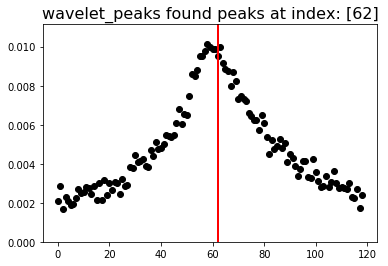

In [8]:
row_ind, col_ind = 103, 19
pixel_ind = col_ind + row_ind * num_cols
spectra = h5_main[pixel_ind]

peak_inds = wavelet_peaks(spectra, peak_widths=[20, 60], peak_step=30)

fig, axis = plt.subplots()
axis.scatter(np.arange(len(spectra)), np.abs(spectra), c='black')
axis.axvline(peak_inds[0], color='r', linewidth=2)
axis.set_ylim([0, 1.1 * np.max(np.abs(spectra))]);
axis.set_title('wavelet_peaks found peaks at index: {}'.format(peak_inds), fontsize=16)

Before we apply the function to the entire dataset, lets load the dataset to memory so that file-loading time is not a factor when comparing the times for serial and parallel computing times:

In [9]:
raw_data = h5_main[()]

Serial computing
----------------
A single call to the function does not take substantial time. However, performing the same operation on each of the 16,384 pixels sequentially can take substantial time. The simplest way to find all peak positions is to simply loop over each position in the dataset:

In [10]:
serial_results = list()

t_0 = time.time()
for ind, vector in enumerate(raw_data):
    serial_results.append(wavelet_peaks(vector, peak_widths=[20, 60], peak_step=30))
print('Serial computation took', np.round(time.time()-t_0, 2), ' seconds')

Serial computation took 65.11  seconds


Parallel Computation
-------------------

There are several libraries that can utilize multiple CPU cores to perform the same computation in parallel. Popular
examples are **Multiprocessing**, **Mutiprocess**, **Dask**, **Joblib** etc. Each of these has their own
strengths and weaknesses. An installation of **Anaconda** comes with **Multiprocessing** by default and could be
the example of choice. However, in our experience we found **Joblib** to offer the best balance of efficiency,
simplicity, portabiity, and ease of installation.

For illustrative purposes, we will only be demonstrating how the above serial computation can be made parallel using
**Joblib**. We only need two lines to perform the parallel computation. The first line sets up the computational
jobs while the second performs the computation.

Note that the first argument to the function **MUST** be the data vector itself. The other arguments (parameters),
such as the frequency vector in this case, must come after the data argument. This approach allows the specification
of both required arguments and optional (keyword) arguments.

Parallel computing has been made more accessible via the **parallel_compute()** function in **pycroscopy.process**. The below parallel computation is reduced to a **single line** with this function.

In [11]:
cpu_cores = 2
kwargs = {'peak_widths': [20, 60], 'peak_step': 30}

t_0 = time.time()

# Set up the parallel computation using joblib.delayed
values = [joblib.delayed(wavelet_peaks)(x, **kwargs) for x in raw_data]
# Execute the parallel computation
parallel_results = joblib.Parallel(n_jobs=cpu_cores)(values)

print('Parallel computation took', np.round(time.time()-t_0, 2), ' seconds')

Parallel computation took 37.38  seconds


Compare the results
-------------------

By comparing the run-times for the two approaches, we see that the parallel computation is substantially faster than
the serial computation. Note that the numbers will differ between computers. Also, the computation was performed on
a relatively small dataset for illustrative purposes. The benefits of using such parallel computation will be far
more apparent for much larger datasets.

Let's compare the results from both the serial and parallel methods to ensure they give the same results:



In [12]:
print('Result from serial computation: {}'.format(serial_results[pixel_ind]))
print('Result from parallel computation: {}'.format(serial_results[pixel_ind]))

Result from serial computation: [62]
Result from parallel computation: [62]


Simplifying the function
-----------------------
Note that the **peak_widths** and **peak_step** arguments will not be changed from one pixel to another. It would be great if we didn't have to keep track of these constant arguments. We can use a very handy python tool called **partial()** to do just this. Below, all we are doing is creating a new function that always pases our prefered values for **peak_widths** and **peak_step** arguments to wavelet_peaks. While it may seem like this is unimportant, it is very convenient when setting up the parallel computing:

In [13]:
find_peaks = partial(wavelet_peaks, peak_widths=[20, 60], peak_step=30)

Let's try calling our simplified function, **find_peak()** to make sure that it results in the same peak index for the aforementioned chosen spectra:

In [14]:
print('find_peaks found peaks at index: {}'.format(find_peaks(h5_main[pixel_ind])))

find_peaks found peaks at index: [62]


Best practices for parallel computing
====================
While it may seem tempting to do everything in parallel, it is important to be aware of some of the trade-offs and
best-practices for parallel computing (multiple CPU cores) when compared to traditional serial computing (single
CPU core):
* There is noticable time overhead involved with setting up each parallel computing job. For very simple or small computations, this overhead may outweigh the speed-up gained with using multiple cores.
* Parallelizing computations that read and write to files at each iteration may be actually be noticably __slower__
than serial computation since each core will compete with all other cores for rights to read and write to the file(s)
and these input/output operations are by far the slowest components of the computation. Instead, it makes sense to
read large amounts of data from the necessary files once, perform the computation, and then write to the files once
after all the computation is complete. In fact, this is what we automatically do in the **Fitter** and
**Process** classes in **pycroscopy**

Scalability
-----------
Lets see how the computation time decreases as the number of CPU cores is increased. This time lets use the find_peaks function instead of wavelet_peaks. The benefit of **partial** will be clearly evident in the set up of the parallel computation - we would not need to specify the keyword arguments (kwargs) at all! Note that this is a very simple function and the benefits of partial will be greater for more complex problems:

In [15]:
def my_parallel_compute(data, func, cpu_cores):
    t_0 = time.time() 
    
    values = [joblib.delayed(func)(x) for x in data]
    # Execute the parallel computation
    parallel_results = joblib.Parallel(n_jobs=cpu_cores)(values)
    # Return only the time difference
    
    return time.time()-t_0

print('Now we will test the speed up for different numbers of CPU cores.\nThis will take some time:')
core_vec = np.arange(1, max(4, cpu_count())+1)
time_vec = []
for cpu_cores in core_vec:
    time_vec.append(my_parallel_compute(raw_data, find_peaks, cpu_cores))

Now we will test the speed up for different numbers of CPU cores:


Depending on your computer (and what was running on your computer along with this computation), you are likely to see diminishing benefits of additional cores beyond 2 cores for this specific problem in the plot below. This is because the dataet is relatively small and each peak-finding operation is relatively quick. The overhead of adding additional cores quickly outweighs the speedup in distributing the work among multiple CPU cores.

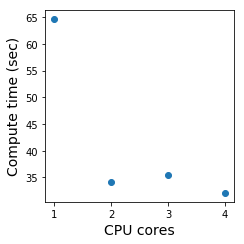

In [16]:
fig, axis = plt.subplots(figsize=(3.5, 3.5))
axis.scatter(core_vec, time_vec)
axis.set_xlabel('CPU cores', fontsize=14)
axis.set_ylabel('Compute time (sec)', fontsize=14)
fig.tight_layout()

Formalizing data processing and pycroscopy.Process
-----------------------------------------------

Data processing / analysis typically involves a few basic operations:
1. Reading data from file
2. Parallel computation
3. Writing results to disk

The Process class in pycroscopy has modularized these operations for simpler and faster development of standardized,
easy-to-debug code. In the case of this example, one would only need to write the wavelet_peaks() function along with the appropriate data reading and data writing functions. Otherc common operations can be inherited from pycroscopy.Process.

Please see another example on how to write a Process class for Pycroscopy based on this example

Lets not forget to close and delete the temporarily downloaded file:

In [17]:
h5_file.close()
os.remove(h5_path)